In [ ]:
#model to predict if surge pricing will take place

import pandas as pd
import numpy as np

#ml imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

trips = pd.read_csv('cab_rides.csv') #reads csv saves as a dataframe

In [ ]:
# ----- Data Cleaning ----- #

#1)converting epoch time to regular datetime

trips['time_stamp'] = pd.to_datetime(trips['time_stamp'], unit = 'ms') #unit is milliseconds for epoch to datetime

#2)can remove id and product id as they are not needed

trips = trips.drop('id', axis = 1)
trips = trips.drop('product_id', axis = 1)

# below commented code shows that all of uber trips have a multiplier of 1, so something is wrong and it is better to use lyft
# print(len(trips.loc[trips['cab_type'] == 'Uber']))
# print(len(trips.loc[(trips['cab_type'] == 'Uber') & (trips['surge_multiplier'] == 1)]))

#3)so remove the uber rows, and can therefore remove the whole cab_type as all are the same

tripsNoUber = trips.loc[trips['cab_type'] == 'Lyft']
trips = tripsNoUber
trips.drop('cab_type', axis = 1)


In [ ]:
#4)One Hot Encode the data at the very end: turns everything into numerical data (0 or 1) to feed into all models
#makes unique columns for each value, turning categorical data into numerical values

tripsDistance = pd.get_dummies(trips['distance'])
#tripsTime = pd.get_dummies(trips['time_stamp'])
tripsDestination = pd.get_dummies(trips['destination'].astype(str))
tripsSource = pd.get_dummies(trips['source'].astype(str))
tripsPrice = pd.get_dummies(trips['price'].astype(str))
tripsSurge = pd.get_dummies(trips['surge_multiplier'].astype(str))
tripsName = pd.get_dummies(trips['name'].astype(str))

#did one hot encoding separately

#5)Time one hot encoding taking too long, so new function for it: "integerize" it

allTimeStamps = trips['time_stamp'].tolist()

def timeStampCompression(timeStamp):
  newTime = ""
  if len(str(timeStamp.date().day)) == 1:
    #then single digit, concat 0
    newTime += str(0)
  newTime += str(timeStamp.date().day)
  #concat extra 0 if single digit for day, hour, minute:

  if len(str(timeStamp.time().hour)) == 1:
    #then single digit, concat 0
    newTime += str(0)
  newTime += str(timeStamp.time().hour)

  if len(str(timeStamp.time().minute)) == 1:
    #then single digit, concat 0
    newTime += str(0)
  newTime += str(timeStamp.time().minute)

  return newTime
  #can ignore seconds and ms
  #also new addition: ignore month
  #going back, actually need the month
  #3rd try, don't need month as no duplicate dates

totalTimes = []

for time in allTimeStamps:
  totalTimes.append(timeStampCompression(time))

#now concatenate all of the lists into one df, as they all have the same length:

tripsTime = pd.DataFrame(totalTimes)

# stringTimes = tripsTime[0].tolist()

# monthStrings = []

# for time in stringTimes:
#   if time[0:2] not in monthStrings:
#     monthStrings.append(time[0:2])

# print(monthStrings)


# print(len(tripsDistance))
# print(len(tripsDestination))
# print(len(tripsSource))
# print(len(tripsPrice))
# print(len(tripsSurge))
# print(len(tripsName))
# print(len(tripsTime))

#reset index of all to avoid null values as concat occurs index wise

# finalTrips = pd.concat([tripsDistance.reset_index(drop=True),
#                         tripsDestination.reset_index(drop=True),
#                         tripsSource.reset_index(drop=True),
#                         tripsPrice.reset_index(drop=True),
#                         tripsSurge.reset_index(drop=True),
#                         tripsName.reset_index(drop=True),
#                         tripsTime.reset_index(drop=True)], axis = 1)

#print(finalTrips) worked!!

In [ ]:
#6) modifications for weather data

#a lot less data entries for weather than trips, so search within weather table
#for each time in the trips and populate a separate column

weather = pd.read_csv('weather.csv')

#all of the no rain entries are null, so replace them with 0

rowNum = -1
for entry in weather['rain']:
  rowNum += 1
  if pd.isnull(entry):
    weather.loc[rowNum, 'rain'] = 0

rowNum = -1
for time in weather['time_stamp']:
  rowNum += 1
  weather.loc[rowNum, 'time_stamp'] = timeStampCompression(pd.to_datetime(time, unit = 's'))

#7) bet, now can match by the time (and location too) as it is compressed in the same way

timeMatchesIndices = []
overallMatches = []

listOfWeatherTimes = weather['time_stamp'].tolist()
listOfTripTimes = totalTimes
listOfWeatherPlaces = weather['location'].tolist()

#for loop with index, use enumerate (don't need rowNum counter like above)

for index, time in enumerate(listOfTripTimes):
  place = finalTrips.loc[index, '2']
  for index, time2 in enumerate(listOfWeatherTimes):
    if time[0:4] == time2[0:4]:
      #just checking if day and hour match: ignore the minutes
      timeMatchesIndices.append(index) #append all matching indices

  for index in timeMatchesIndices:
    finalTrips



In [ ]:
# ----- Machine Learning Model ----- #

#independent and dependent

#independent is everything except surge, dependent is surge
X = pd.concat([tripsDistance.reset_index(drop=True),
                          tripsDestination.reset_index(drop=True),
                          tripsSource.reset_index(drop=True),
                          tripsPrice.reset_index(drop=True),
                          tripsName.reset_index(drop=True),
                          tripsTime.reset_index(drop=True)], axis = 1)
y = tripsSurge

X.columns = X.columns.astype(str)
y.columns = y.columns.astype(str)

#train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1234)

#test size is 30 percent, random state is 1234

rfModel = RandomForestClassifier(n_estimators = 64, max_depth = 10,
                                 min_samples_split = 4, max_leaf_nodes = 25,
                                 min_samples_leaf = 3, max_samples = 0.2,
                                 max_features = 3)
rfModel.fit(X_train, y_train)

y_pred = rfModel.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred))

New attempt at ML Model: using 3 features as independent this time (amount of trips in the 20 minute period, amount of trips in the area, weather at the time)

In [ ]:
import pandas as pd
import numpy as np
import random

trips = pd.read_csv('cab_rides.csv')
weather = pd.read_csv('weather.csv')

trips = trips.loc[trips['cab_type'] == 'Lyft'] #removes uber rows
trips = trips.reset_index() #very important to reset index after dropping

#separate trips data that do have a surge vs don't to even it out

tripsNoSurge = trips.loc[trips['surge_multiplier'] == 1]
tripsSurge = trips.loc[trips['surge_multiplier'] != 1]

tripsNoSurge.reset_index()
tripsSurge.reset_index()

#keep all the ones where surge is used
#keep 1/10 of the nosurge trips

tripsNoSurge = tripsNoSurge.sample(20975)

trips = pd.concat([tripsSurge.reset_index(drop=True),
                        tripsNoSurge.reset_index(drop=True)], axis = 0)

trips.reset_index()

#reset_index(drop=True) while concatenating!!!

#took random sample of regularList to make it same size as surgeList ^^^

#print(len(masterData)) #should be around 41950 - it is

#20975 rows with surge, around that many without

#smallest ratio of features to amount of data is the best for machine learning:
#this ratio is 3:41950 - that's good!

In [71]:
tripTimes = []

for time in trips['time_stamp']:
  realTime = pd.to_datetime(time, unit = 'ms')
  tripTimes.append(realTime)

trips.drop('distance', axis = 1, inplace = True) #removes distance column
trips.drop('price', axis = 1, inplace = True) #removes price column
trips.drop('id', axis = 1, inplace = True) #removes id column
trips.drop('product_id', axis = 1, inplace = True) #removes product id column
trips.drop('name', axis = 1, inplace = True) #removes name column
trips.drop('time_stamp', axis = 1, inplace = True) #removes time column

trips['time'] = tripTimes

weatherTimes = []

for time in weather['time_stamp']:
  realTime = pd.to_datetime(time, unit = 's')
  weatherTimes.append(realTime)

weather.drop('clouds', axis = 1, inplace = True) #removes clouds column
weather.drop('pressure', axis = 1, inplace = True) #removes pressure column
weather.drop('humidity', axis = 1, inplace = True) #removes humidity column
weather.drop('wind', axis = 1, inplace = True) #removes wind column
weather.drop('time_stamp', axis = 1, inplace = True) #removes time column

weather['time'] = weatherTimes

In [72]:
#time compression into 20 minute intervals, so can be merged by time AND location

daysListTrips = []
hoursListTrips = []
minutesListTrips = []

for time in trips['time']:
  daysListTrips.append(time.date().day)
  hoursListTrips.append(time.time().hour)
  if time.time().minute in range(0,20):
    minutesListTrips.append(1)
  elif time.time().minute in range(20,40):
    minutesListTrips.append(2)
  else:
    minutesListTrips.append(3)

trips['day'] = daysListTrips
trips['hour'] = hoursListTrips
trips['minute'] = minutesListTrips

trips.drop('time', axis = 1, inplace=True)
trips.reset_index()

daysListWeather = []
hoursListWeather = []
minutesListWeather = []

for time in weather['time']:
  daysListWeather.append(time.date().day)
  hoursListWeather.append(time.time().hour)
  if time.time().minute in range(0,20):
    minutesListWeather.append(1)
  elif time.time().minute in range(20,40):
    minutesListWeather.append(2)
  else:
    minutesListWeather.append(3)

weather.drop('time', axis = 1, inplace=True)
weather.reset_index()

weather['day'] = daysListWeather
weather['hour'] = hoursListWeather
weather['minute'] = minutesListWeather

#also replace all the null weather with 0s

weather['rain'] = weather['rain'].fillna(0)

#weather data should be all unique

weather = weather.drop_duplicates(['location', 'day', 'hour'])

#take out minute from the duplicates now - using hourly weather data

#remove duplicates for subset of location day hour minute, default keeps one of them
#now there's one weather forecast per 20 minute period for every location

#done

In [73]:
#now can left join trips and weather on location, day, hour, minute

masterData = pd.merge(trips,
                      weather,
                      left_on=['source', 'day', 'hour'],
                      right_on=['location', 'day', 'hour'],
                      how = 'left')

masterData.reset_index()

masterData.drop('index', axis = 1, inplace=True)
masterData.drop('cab_type', axis = 1, inplace=True)
masterData.drop('location', axis = 1, inplace=True) #because same as source
masterData.drop('day', axis = 1, inplace=True)
masterData.drop('hour', axis = 1, inplace=True)
masterData.drop('minute_x', axis = 1, inplace=True)
masterData.drop('minute_y', axis = 1, inplace=True)

#print(masterData)

#remove the rows where rain is null (there is no weather data) - same as temp being null

masterData = masterData.loc[np.isfinite(masterData['rain'])] #isfinite is opposite of isnan

#some rows have missing weather data though, so may have to make scope larger than 20 minutes
#made the scope one hour, now there is less missing data: merged without the minute breakdown
#some locations don't have hourly weather data
#must remove 176 rows from data as there is no matching weather data: that's ok

#now master data has 41774 rows (41950 - 176)
#worked

In [74]:
#now add algorithms to include columns for the trips every 20 minutes and trips per location

#1)historic number of trips every 20 min over days: group trips by hour and minute

groupedByTime = trips.groupby(['hour', 'minute'], as_index=False)
#remember as_index = False to make df


#now merge this with trips

trips = pd.merge(trips,
                 groupedByTime.size(), #merge the size not the group by!!!
                 on=['hour', 'minute'],
                 how='left')

#now have historic amount of trips during that time

In [75]:
#2)historic number of trips in that zone

groupedByZone = trips.groupby(['source'], as_index=False)

trips = pd.merge(trips,
                 groupedByZone.size(),
                 on = 'source',
                 how = 'left')

print(trips)
#finally add the size_x and size_y columns to the masterData

masterData['amountInTime'] = trips['size_x']
masterData['amountInZone'] = trips['size_y']

#classification not regression

for index, surge in enumerate(masterData['surge_multiplier']):
  if surge == 1:
    masterData['surge_multiplier'].iloc[index] = 0
  else:
    masterData['surge_multiplier'].iloc[index] = 1


print(masterData)
#0 means in use, 1 means not in use

#ready for random forest model

        index cab_type         destination                   source  \
0         266     Lyft    Theatre District            South Station   
1         268     Lyft    Theatre District            South Station   
2         269     Lyft    Theatre District            South Station   
3         270     Lyft    Theatre District            South Station   
4         271     Lyft    Theatre District            South Station   
...       ...      ...                 ...                      ...   
41945  309800     Lyft  Financial District  Northeastern University   
41946   16104     Lyft       North Station  Northeastern University   
41947   26156     Lyft         Beacon Hill                   Fenway   
41948  519707     Lyft   Boston University       Financial District   
41949  513297     Lyft              Fenway                 West End   

       surge_multiplier  day  hour  minute  size_x  size_y  
0                  1.25    3    14       2     558    3474  
1                  1.25  

<ipython-input-75-689dd6a6a5e0>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  masterData['surge_multiplier'].iloc[index] = 1
<ipython-input-75-689dd6a6a5e0>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  masterData['surge_multiplier'].iloc[index] = 0


              destination                   source  surge_multiplier   temp  \
0        Theatre District            South Station               1.0  52.65   
1        Theatre District            South Station               1.0  20.36   
2        Theatre District            South Station               1.0  36.76   
3        Theatre District            South Station               1.0  42.83   
4        Theatre District            South Station               1.0  42.64   
...                   ...                      ...               ...    ...   
41945  Financial District  Northeastern University               0.0  43.66   
41946       North Station  Northeastern University               0.0  39.10   
41947         Beacon Hill                   Fenway               0.0  44.63   
41948   Boston University       Financial District               0.0  45.54   
41949              Fenway                 West End               0.0  27.34   

         rain  amountInTime  amountInZone  
0      

In [76]:
masterData.drop('destination', axis = 1, inplace=True)
masterData.drop('source', axis = 1, inplace=True)

       surge_multiplier   temp    rain  amountInTime  amountInZone
0                   1.0  52.65  0.0000           558          3474
1                   1.0  20.36  0.0000           652          3474
2                   1.0  36.76  0.0000           513          3474
3                   1.0  42.83  0.0000           597          3474
4                   1.0  42.64  0.0000           587          3474
...                 ...    ...     ...           ...           ...
41945               0.0  43.66  0.0062           626          4315
41946               0.0  39.10  0.0000           667          4315
41947               0.0  44.63  0.0133           585          4288
41948               0.0  45.54  0.0000           670          3363
41949               0.0  27.34  0.0000           526          2781

[41768 rows x 5 columns]
accuracy:  0.6168701619982444
f1:  0.6295624346637781


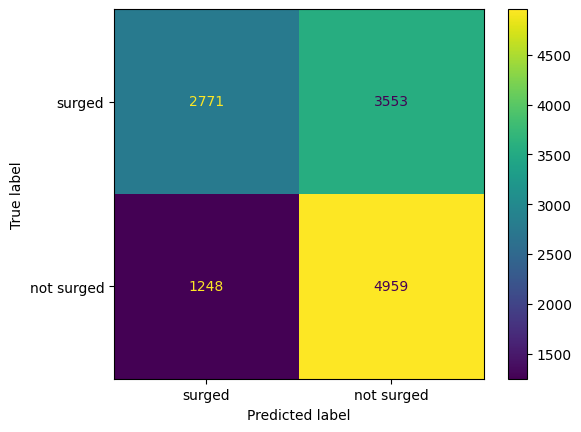

In [77]:
print(masterData)
#ml imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.naive_bayes import GaussianNB

#1) Naive Bayes machine learning model

X = masterData.drop('surge_multiplier', axis = 1)
y = masterData['surge_multiplier']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1234)

model = GaussianNB() #Naive Bayes model

model.fit(X_train, y_train) #training

y_pred = model.predict(X_test) #predict on the X_test

accuracy = accuracy_score(y_pred, y_test) #check accuracy between pred and test
f1 = f1_score(y_pred, y_test, average = 'weighted') #check f1 score

print("accuracy: ", accuracy)
print("f1: ", f1)

#confusion matrix to see

labels = ['surged', 'not surged']
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

#accuracy is around 62%
#predicts not surged when it actually is surged

accuracy:  0.5924684857188447
f1:  0.6240247313410864


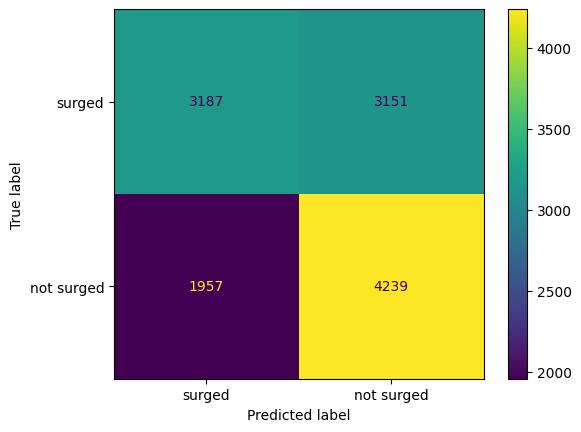

In [68]:
#logistic regression model

#ml imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

X = masterData.drop('surge_multiplier', axis = 1) #features
y = masterData['surge_multiplier'] #target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1234)

from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(random_state = 1234) #create model with fixed random state

logreg.fit(X_train, y_train) #fit model

y_pred = logreg.predict(X_test) #predict on x test

accuracy = accuracy_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test)

print('accuracy: ', accuracy)
print('f1: ', f1)

labels = ['surged', 'not surged']
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)
disp.plot()

#accuracy is around 60%
#predicts not surged when it actually is surged